In [8]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import time
tfd = tfp.distributions

In [23]:
# Settings
D = 24   #number of dimensions
N = 1000 #number of datapoints to generate
EPOCHS = 300
BATCH_SIZE = 50
L_RATE = 0.005

# Generate data
b_true = np.random.randn(1)
w_true = np.random.randn(D, 1)
x = np.random.randn(N, D)
noise = 0.2 * np.random.randn(N,1)
y = x @ w_true + b_true + noise

# Cast to float32
x = x.astype('float32')
y = y.astype('float32')

# Make a TensorFlow Dataset from training data
data_train = tf.data.Dataset.from_tensor_slices(
    (x, y)).shuffle(10000).batch(BATCH_SIZE)

In [24]:
class BayesianLinearRegression(tf.keras.Model):


    def __init__(self, d, name=None):
        super(BayesianLinearRegression, self).__init__(name=name)
        self.w_loc = tf.Variable(tf.random.normal([d, 1]), name='w_loc')
        self.w_std = tf.Variable(tf.random.normal([d, 1]), name='w_std')
        self.b_loc = tf.Variable(tf.random.normal([1]), name='b_loc')
        self.b_std = tf.Variable(tf.random.normal([1]), name='b_std')
        self.s_alpha = tf.Variable(tf.exp(tf.random.normal([1])), name='s_alpha')
        self.s_beta = tf.Variable(tf.exp(tf.random.normal([1])), name='s_beta')
    
    
    @property
    def weight(self):
        """Variational posterior for the weight"""
        return tfd.Normal(self.w_loc, tf.exp(self.w_std))
    
    
    @property
    def bias(self):
        """Variational posterior for the bias"""
        return tfd.Normal(self.b_loc, tf.exp(self.b_std))


    @property
    def std(self):
        """Variational posterior for the noise standard deviation"""
        return tfd.InverseGamma(tf.exp(self.s_alpha), tf.exp(self.s_beta))

    
    def call(self, x, sampling=True):
        """Predict p(y|x)"""
        sample = lambda x: x.sample() if sampling else x.mean()
        loc = x @ sample(self.weight) + sample(self.bias)
        std = tf.sqrt(sample(self.std))
        return tfd.Normal(loc, std)
    
    
    @property
    def losses(self):
        """Sum of KL divergences between posteriors and priors"""
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(self.weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(self.bias, prior)))

In [ ]:
tfd.multinomial()

In [25]:
model = BayesianLinearRegression(D)


In [26]:
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_prob = tf.reduce_mean(model(x_data).log_prob(y_data))
        kl_loss = model.losses/N
        elbo_loss = kl_loss - log_prob
    gradients = tape.gradient(elbo_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [27]:
# Fit the model
st = time.time()
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        train_step(x_data, y_data)
print(time.time() - st)

6.695219278335571


/Users/Yves/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


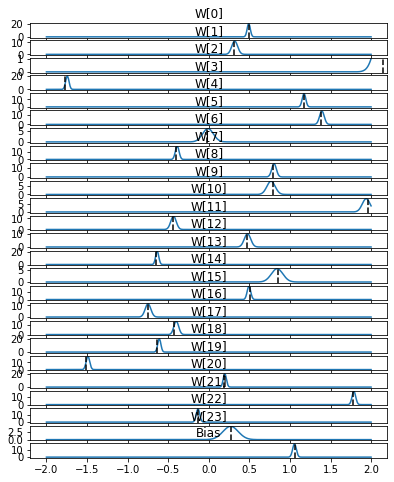

In [28]:
fig = plt.figure()
fig.set_size_inches(6.4, 8)
v = np.linspace(-2, 2, 400)

# Plot weight posteriors
probs = model.weight.prob(v*np.ones([D, 1]))
for i in range(D):
    plt.subplot(D+1, 1, i+1)
    plt.plot(v, probs[i, :])
    plt.axvline(x=w_true[i], linestyle='--', color='k')
    plt.title('W[{}]'.format(i))
    
# Plot Bias posterior
plt.subplot(D+1, 1, D+1)
plt.plot(v, model.bias.prob(v))
plt.axvline(x=b_true, linestyle='--', color='k')
plt.title('Bias')

plt.tight_layout()
plt.show()